<a href="https://colab.research.google.com/github/Saketkr06/NLP/blob/main/Practical_NLP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install gensim
!pip install spacy
!pip install nltk

In [10]:
!pip install scikit-learn

In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

In [13]:
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
    !ls -lah DATAPATH
    our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

except ModuleNotFoundError:
    our_data = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

--2023-08-10 16:41:12--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  --.-KB/s    in 0.07s   

2023-08-10 16:41:12 (179 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 root root 4.0K Aug 10 16:41 .
drwxr-xr-x 1 root root 4.0K Aug 10 16:41 ..
-rw-r--r-- 1 root root  12M Aug 10 16:41 Full-Economic-News-DFE-839861.csv


In [14]:
display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [15]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0.
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
our_data.shape

(7991, 2)

In [17]:
stopwords = _stop_words.ENGLISH_STOP_WORDS
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

In [18]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.text # the column text contains textual data to extract features from
y = our_data.relevance # this is the column we are learning to predict.
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [19]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [20]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

CPU times: user 12.2 ms, sys: 882 µs, total: 13.1 ms
Wall time: 35.7 ms


Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


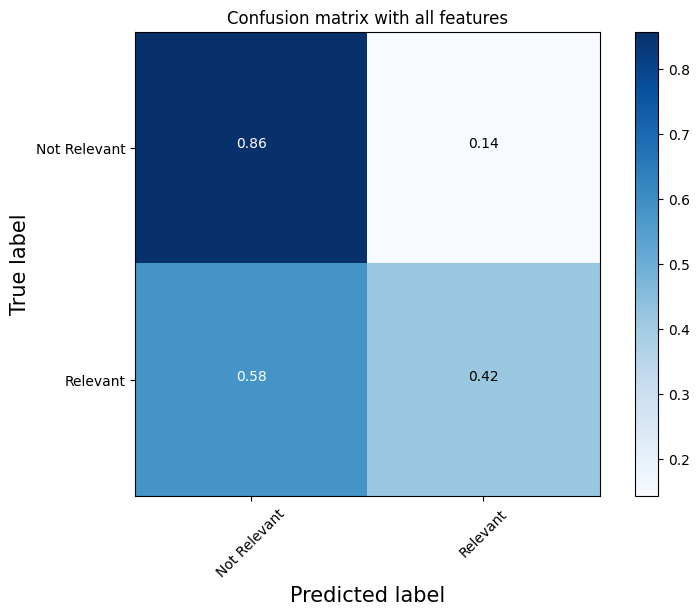

In [21]:
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)


# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))


Accuracy:  0.7682682682682682
AUC:  0.7251117679464362


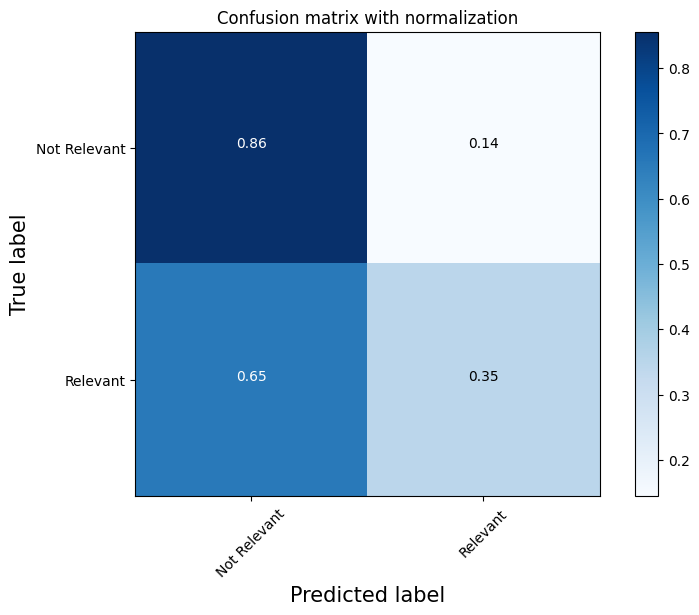

In [22]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

In [24]:
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [27]:
!pip install fasttext==0.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=768eb5eb4e3156018be4f5320c1c544e6f6c8ae6ecd8e65fd4f8bfeee29b4cce
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [28]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e122a31440722108cdcccc55583098018ee50a6f740d2f5df3776456b44d65ca
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [29]:
#necessary imports
import os
import pandas as pd
import wget
import tarfile

--2023-08-10 16:57:08--  https://github.com/le-scientifique/torchDatasets/raw/master/dbpedia_csv.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/le-scientifique/torchDatasets/master/dbpedia_csv.tar.gz [following]
--2023-08-10 16:57:08--  https://raw.githubusercontent.com/le-scientifique/torchDatasets/master/dbpedia_csv.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115 [application/octet-stream]
Saving to: ‘DATAPATH/dbpedia_csv.tar.gz’

dbpedia_csv.tar.gz  100%[===================>]     115  --.-KB/s    in 0s      

2023-08-10 16:57:08 (3.64 MB/s) - ‘DATAPATH/dbpedia_csv.tar.gz’ s

In [33]:
#Make the necessary imports
import os
import sys
import numpy as np
import tarfile
import wget
import warnings
warnings.filterwarnings("ignore")
from zipfile import ZipFile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

In [35]:
%%capture
try:

    from google.colab import files

    !wget -P DATAPATH http://nlp.stanford.edu/data/glove.6B.zip
    !unzip DATAPATH/glove.6B.zip -d DATAPATH/glove.6B

    !wget -P DATAPATH http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xvf DATAPATH/aclImdb_v1.tar.gz -C DATAPATH

    BASE_DIR = 'DATAPATH'

except ModuleNotFoundError:

    if not os.path.exists('Data/glove.6B'):
        os.mkdir('Data/glove.6B')

        url='http://nlp.stanford.edu/data/glove.6B.zip'
        wget.download(url,'Data')

        temp='Data/glove.6B.zip'
        file = ZipFile(temp)
        file.extractall('Data/glove.6B')
        file.close()



    if not os.path.exists('Data/aclImdb'):

        url='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        wget.download(url,'Data')

        temp='Data/aclImdb_v1.tar.gz'
        tar = tarfile.open(temp, "r:gz")
        tar.extractall('Data')
        tar.close()

    BASE_DIR = 'Data'

In [ ]:
BASE_DIR = '/content/DATAPATH'

In [39]:
GLOVE_DIR = '/content/DATAPATH/glove.6B'
TRAIN_DATA_DIR = '/content/DATAPATH/aclImdb/train'
TEST_DATA_DIR = '/content/DATAPATH/aclImdb/test'

In [40]:
#Within these, I only have a pos/ and a neg/ folder containing text files
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [41]:
#Function to load the data from the dataset into the notebook. Will be called twice - for train and test.
def get_data(data_dir):
    texts = []  # list of text samples
    labels_index = {'pos':1, 'neg':0}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if os.path.isdir(path):
            if name=='pos' or name=='neg':
                label_id = labels_index[name]
                for fname in sorted(os.listdir(path)):
                        fpath = os.path.join(path, fname)
                        text = open(fpath,encoding='utf8').read()
                        texts.append(text)
                        labels.append(label_id)
    return texts, labels

train_texts, train_labels = get_data(TRAIN_DATA_DIR)
test_texts, test_labels = get_data(TEST_DATA_DIR)
labels_index = {'pos':1, 'neg':0}

In [42]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts) #Converting text to a vector of word indexes
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [43]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trainvalid_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]
#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


In [44]:
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
#print(embeddings_index["google"])

# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.
Preparing of embedding matrix is done


In [45]:
print('Define a 1D CNN model')
cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(len(labels_index), activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
#Train the model. Tune to validation set.
cnnmodel.fit(x_train, y_train,
          batch_size=128,
          epochs=1, validation_data=(x_val, y_val))
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Define a 1D CNN model
782/782 [==============================] - 59s 75ms/step - loss: 0.7749 - acc: 0.6019
Test accuracy with CNN: 0.6018800139427185


In [46]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel = Sequential()
cnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(len(labels_index), activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
#Train the model. Tune to validation set.
cnnmodel.fit(x_train, y_train,
          batch_size=128,
          epochs=1, validation_data=(x_val, y_val))
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
782/782 [==============================] - 69s 88ms/step - loss: 0.6146 - acc: 0.6401
Test accuracy with CNN: 0.6401200294494629


In [47]:
print("Defining and training an LSTM model, training embedding layer on the fly")

#model
rnnmodel = Sequential()
rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel.add(Dense(2, activation='sigmoid'))
rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_val, y_val))
score, acc = rnnmodel.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

Defining and training an LSTM model, training embedding layer on the fly
Training the RNN
782/782 [==============================] - 194s 248ms/step - loss: 0.4282 - accuracy: 0.8195
Test accuracy with RNN: 0.8194800019264221


In [48]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(2, activation='sigmoid'))
rnnmodel2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel2.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_val, y_val))
score, acc = rnnmodel2.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

Defining and training an LSTM model, using pre-trained embedding layer
Training the RNN
782/782 [==============================] - 179s 229ms/step - loss: 0.4774 - accuracy: 0.7894
Test accuracy with RNN: 0.7893999814987183
